In [3]:
import pandas as pd

X_train = pd.read_csv("data/X_train.csv")
X_val   = pd.read_csv("data/X_val.csv")
X_test  = pd.read_csv("data/X_test.csv")

y_train = pd.read_csv("data/y_train.csv")
y_val   = pd.read_csv("data/y_val.csv")
y_test  = pd.read_csv("data/y_test.csv")

import joblib
final_model = joblib.load("models/final_day5_bestmodel.pkl")

y_val_proba = final_model.predict_proba(X_val)[:,1]


In [4]:
y_train_proba = final_model.predict_proba(X_train)[:,1]
y_test_proba  = final_model.predict_proba(X_test)[:,1]


In [5]:
#Create Risk Segments

def risk_bucket(prob):
    if prob < 0.35:
        return 'High Risk'
    elif prob < 0.70:
        return 'Medium Risk'
    else:
        return 'Low Risk'

risk_segments = pd.Series(y_val_proba).apply(risk_bucket)


In [6]:
X_val_risk = X_val.copy()
X_val_risk['risk_segment'] = risk_segments
X_val_risk['approval_probability'] = y_val_proba
X_val_risk['actual_status'] = y_val.values


In [7]:
# Analyze Each Risk Segment

risk_analysis = X_val_risk.groupby('risk_segment').agg({
    'person_income': 'mean',
    'credit_score': 'mean',
    'loan_percent_income': 'mean',
    'actual_status': ['mean', 'count']
})

risk_analysis


person_income credit_score loan_percent_income actual_status  \
                      mean         mean                mean          mean   
risk_segment                                                                
High Risk     91943.377961   636.240347            0.118963      0.031670   
Low Risk      57243.749331   633.565056            0.225967      0.951673   
Medium Risk   74418.726115   639.707006            0.138599      0.471338   

                    
             count  
risk_segment        
High Risk     2305  
Low Risk       538  
Medium Risk    157

<Axes: xlabel='risk_segment'>

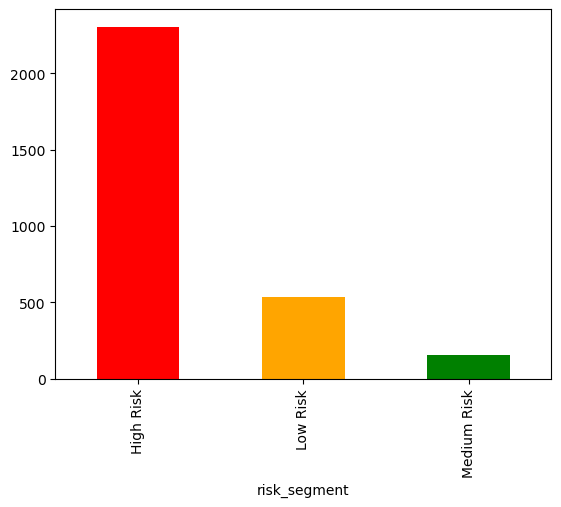

In [8]:
#Plot Risk Segment Distribution

X_val_risk['risk_segment'].value_counts().plot(kind='bar', color=['red','orange','green'])


In [9]:
#Policy Simulation (VERY IMPORTANT)

new_preds = (y_val_proba >= 0.65).astype(int)


In [10]:
from sklearn.metrics import confusion_matrix

old_policy = y_val.values
new_policy = new_preds

confusion_matrix(old_policy, new_policy)


array([[2310,   31],
       [ 134,  525]])

In [11]:
import numpy as np

old_approvals = old_policy.sum()
new_approvals = new_policy.sum()

print("Old Approvals:", old_approvals)
print("New Approvals:", new_approvals)
print("Reduction:", old_approvals - new_approvals)


Old Approvals: 659
New Approvals: 556
Reduction: 103


In [12]:
#Create a Risk Dashboard

risk_dashboard = pd.DataFrame({
    'Segment': ['Low Risk', 'Medium Risk', 'High Risk'],
    'Customer Count': X_val_risk['risk_segment'].value_counts(),
    'Avg Credit Score': X_val_risk.groupby('risk_segment')['credit_score'].mean().round(2),
    'Avg Income': X_val_risk.groupby('risk_segment')['person_income'].mean().round(2),
    'Avg Loan % Income': X_val_risk.groupby('risk_segment')['loan_percent_income'].mean().round(3),
    'Historical Approval Rate': X_val_risk.groupby('risk_segment')['actual_status'].mean().round(3)
})
risk_dashboard


,Segment,Customer Count,Avg Credit Score,Avg Income,Avg Loan % Income,Historical Approval Rate
risk_segment,,,,,,
High Risk,Low Risk,2305,636.24,91943.38,0.119,0.032
Low Risk,Medium Risk,538,633.57,57243.75,0.226,0.952
Medium Risk,High Risk,157,639.71,74418.73,0.139,0.471
